# DM - Clustering analysis [TASK 2]

In [2]:
import json
import math
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import fetch_preprocessed_dataset, store_preprocessed_dataset
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

import sys
import logging as lg

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

/tmp/ipykernel_377633/1311723295.py:10: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [3]:
# 
# Load the CSV
#
dataset = fetch_preprocessed_dataset(step_name="users_total")
users = dataset['users.pickle']

In [6]:
users_num_cols = ['statuses_count', 'bot', 'tweets_num', 'tweets_2020_num', 'likes_num', 'comments_num', 'entropy', 'ratio_likes_x_tweets', 'texts_mean_length', 'texts_special_chars_length']

user_num = users[users_num_cols].astype({'bot': 'int64'}).dropna()

In [7]:
scaler = StandardScaler()
scaler.fit(user_num.values)

StandardScaler()

In [9]:
scaled_values = scaler.transform(user_num.values)
scaled_values

array([[-0.29867082,  0.93894727, -0.16714594, ..., -0.05690704,
        -0.41045071, -0.27046731],
       [-0.29984298, -1.06502253, -0.16714594, ..., -0.05690704,
        -0.01748804, -0.30490511],
       [-0.30256026,  0.93894727, -0.16714594, ..., -0.05690704,
        -3.18076767, -0.24902242],
       ...,
       [-0.30240042, -1.06502253, -0.16714594, ..., -0.05690704,
        -0.15542399, -0.05436883],
       [-0.30048234,  0.93894727, -0.16714594, ..., -0.05690704,
        -0.27062747, -0.26685559],
       [-0.02145513, -1.06502253, -0.16714594, ..., -0.05690704,
        -0.99460642, -0.35151397]])

## KMeans

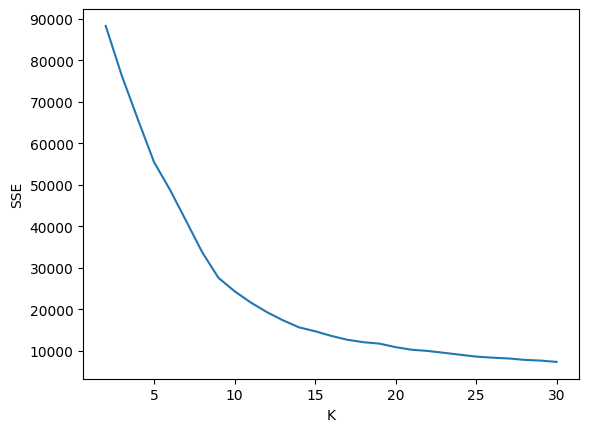

In [10]:
sse_list = []
max_k = 30
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(scaled_values)

    sse = kmeans.inertia_
    sse_list.append(sse)

plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.show()

In [11]:
kmeans = KMeans(n_clusters=15, n_init=10, max_iter=100)
kmeans.fit(scaled_values)

print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % silhouette_score(scaled_values, kmeans.labels_))
print('Separation %s' % metrics.davies_bouldin_score(scaled_values, kmeans.labels_))

SSE 14517.94628653382
Silhouette 0.5083655440712939
Separation 0.6309570256099277


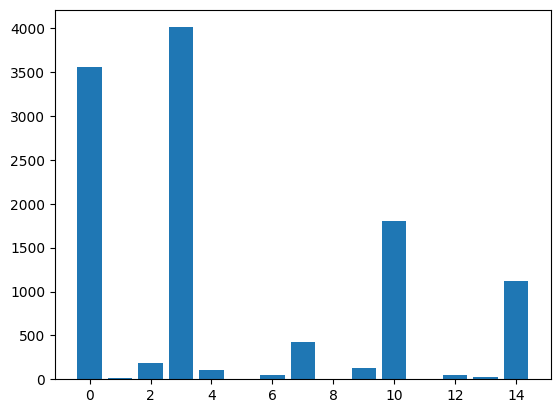

In [12]:
labels_distribution = np.unique(kmeans.labels_, return_counts=True)
plt.bar(labels_distribution[0], labels_distribution[1])
plt.show()

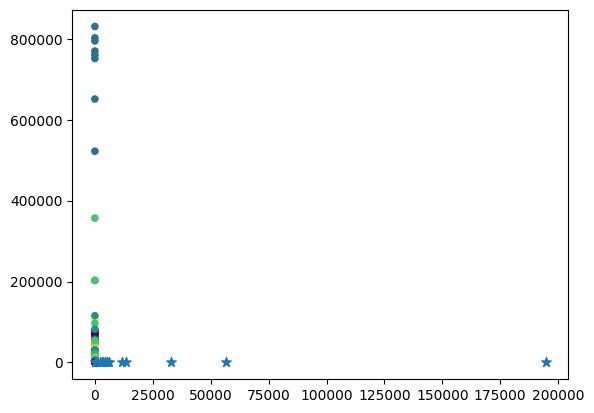

In [16]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

plt.scatter(user_num['tweets_num'], user_num['likes_num'], c=kmeans.labels_, s=20)
plt.scatter(centers[:, 0], centers[:, 1], s=50, marker='*')
plt.show()

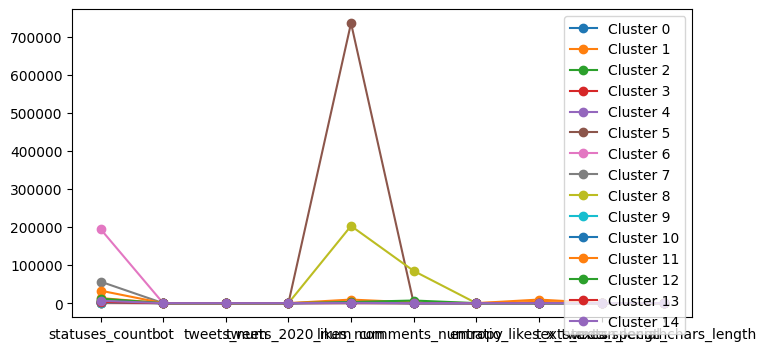

In [17]:
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(0, len(user_num.columns)), user_num.columns)
plt.legend(fontsize=10)
plt.show()

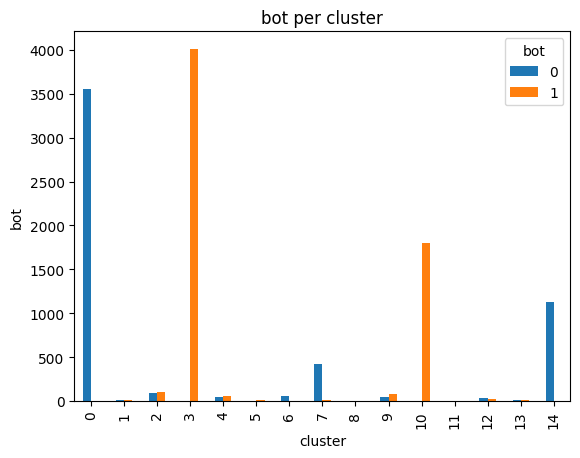

In [18]:
users_pct = pd.crosstab(kmeans.labels_, user_num['bot'])

users_pct.plot(kind='bar', stacked=False,
                   title='bot per cluster')
plt.xlabel('cluster')
plt.ylabel('bot')
plt.show()

## DBSCAN

In [19]:
dist = pdist(user_num, 'euclidean') #pair wise distance
dist = squareform(dist)
print(dist)

[[   0.           22.99811659   86.47768866 ...   70.36130094
    34.21130532 5220.83004872]
 [  22.99811659    0.           73.54030666 ...   48.52098183
    12.92072315 5242.68915608]
 [  86.47768866   73.54030666    0.         ...   50.48652185
    62.68348513 5294.10968977]
 ...
 [  70.36130094   48.52098183   50.48652185 ...    0.
    37.02919574 5291.01432765]
 [  34.21130532   12.92072315   62.68348513 ...   37.02919574
     0.         5254.47429454]
 [5220.83004872 5242.68915608 5294.10968977 ... 5291.01432765
  5254.47429454    0.        ]]


In [26]:
k = 30
kth_distances = []
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

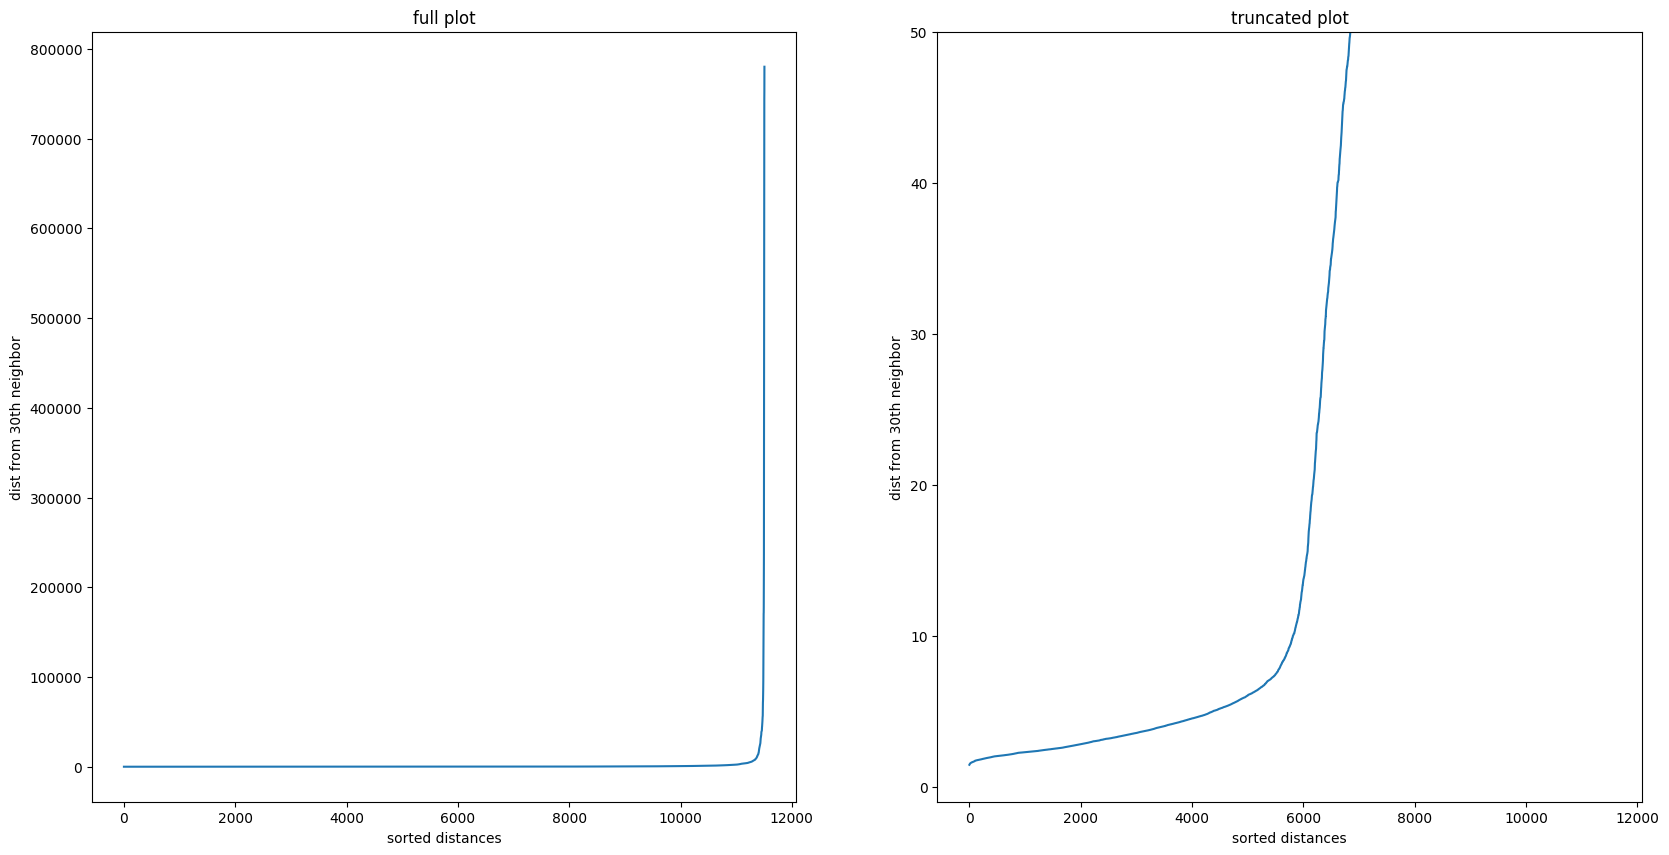

In [36]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('full plot')
ax1.plot(range(0, len(kth_distances)), sorted(kth_distances))

ax2.set_title('truncated plot')
ax2.plot(range(0, len(kth_distances)), sorted(kth_distances))
ax2.set_ylim([-1, 50])

for ax in [ax1, ax2]:
    ax.set_ylabel('dist from %sth neighbor' % k)
    ax.set_xlabel('sorted distances')

plt.show()

In [37]:
dbscan = DBSCAN(eps=8, min_samples=k)
dbscan.fit(scaled_values)

print('Silhouette %s' % silhouette_score(scaled_values, kmeans.labels_))
print('Separation %s' % metrics.davies_bouldin_score(scaled_values, kmeans.labels_))

Silhouette 0.5083655440712939
Separation 0.6309570256099277


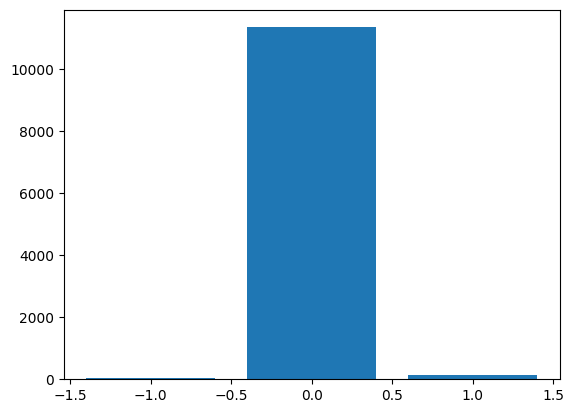

In [38]:
labels_distribution = np.unique(dbscan.labels_, return_counts=True)
plt.bar(labels_distribution[0], labels_distribution[1])
plt.show()

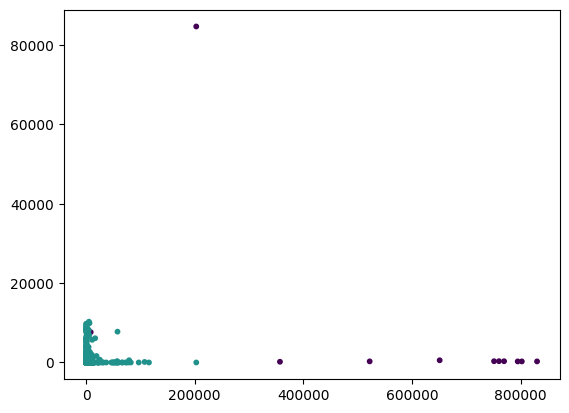

In [45]:
plt.scatter(user_num['likes_num'], user_num['comments_num'], c=dbscan.labels_, s=10)
plt.show()

## Hierarchical

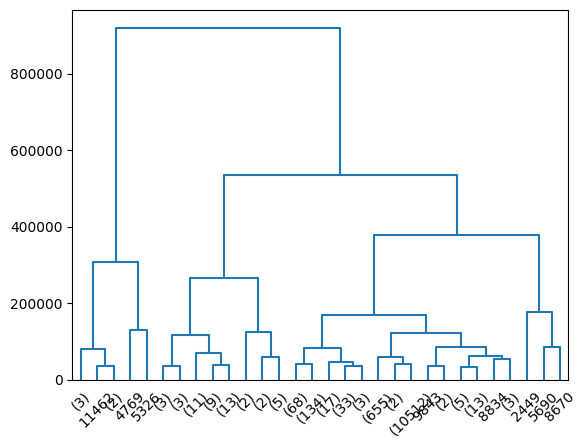

In [46]:
data_dist = pdist(user_num, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

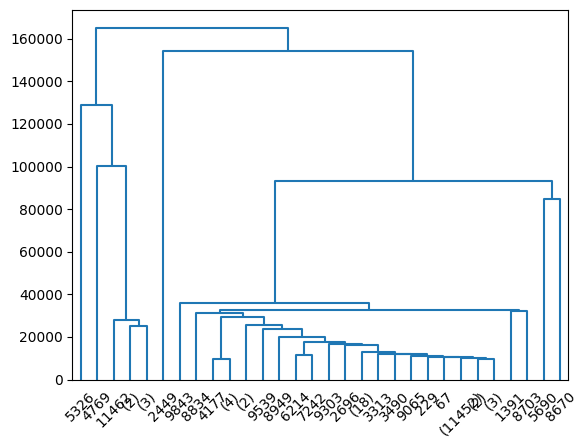

In [60]:
data_dist = pdist(user_num, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')

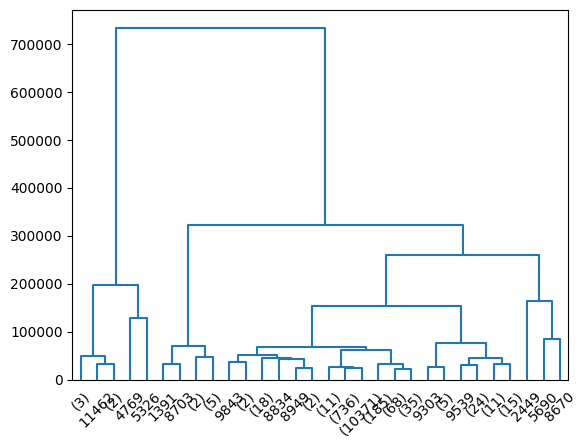

In [50]:
data_dist = pdist(user_num, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

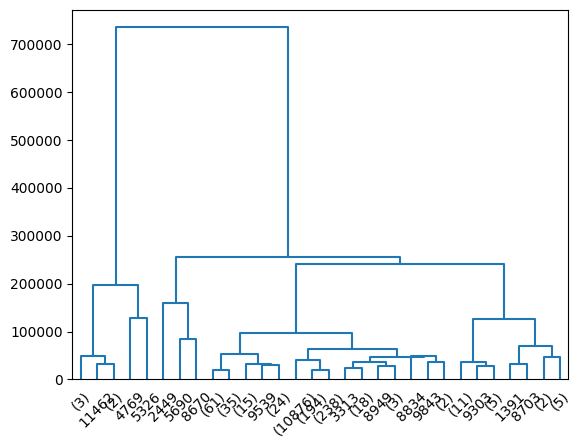

In [51]:
data_dist = pdist(user_num, metric='euclidean')
data_link = linkage(data_dist, method='centroid', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

## XMeans

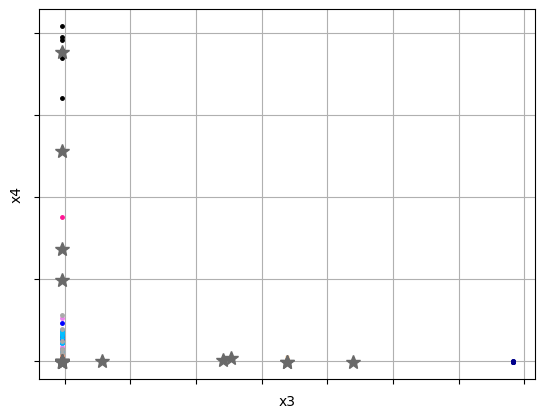

In [62]:
from pyclustering.cluster import cluster_visualizer, cluster_visualizer_multidim
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

sample = scaled_values

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(sample, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(sample, initial_centers, 20)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

# Visualize clustering results
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, sample.tolist())
visualizer.append_cluster(centers, None, marker='*', markersize=10)
visualizer.show(pair_filter=[[3, 4]])